# Alzheimer's Disease Classification using Vision Transformer (ViT)

This notebook uses a pre-trained Vision Transformer (ViT-B/16) model to classify MRI images into four categories of Alzheimer's disease:
- AD (Alzheimer's Disease)
- CN (Cognitively Normal)
- EMCI (Early Mild Cognitive Impairment)
- LMCI (Late Mild Cognitive Impairment)


In [1]:
# First, let's check if torchvision is installed
import torch
import torch.nn as nn
print(f"PyTorch version: {torch.__version__}")

try:
    import torchvision
    print(f"torchvision version: {torchvision.__version__}")
except ImportError:
    print("torchvision is not installed. Please run: pip install torchvision")


PyTorch version: 2.6.0
torchvision version: 0.21.0


In [2]:
%load_ext autoreload
%autoreload 2

## Importing the Alzheimer's ViT Module

First, let's import all the necessary functions from our `alzheimer_vit.py` file.

Using MPS device
PyTorch version: 2.6.0


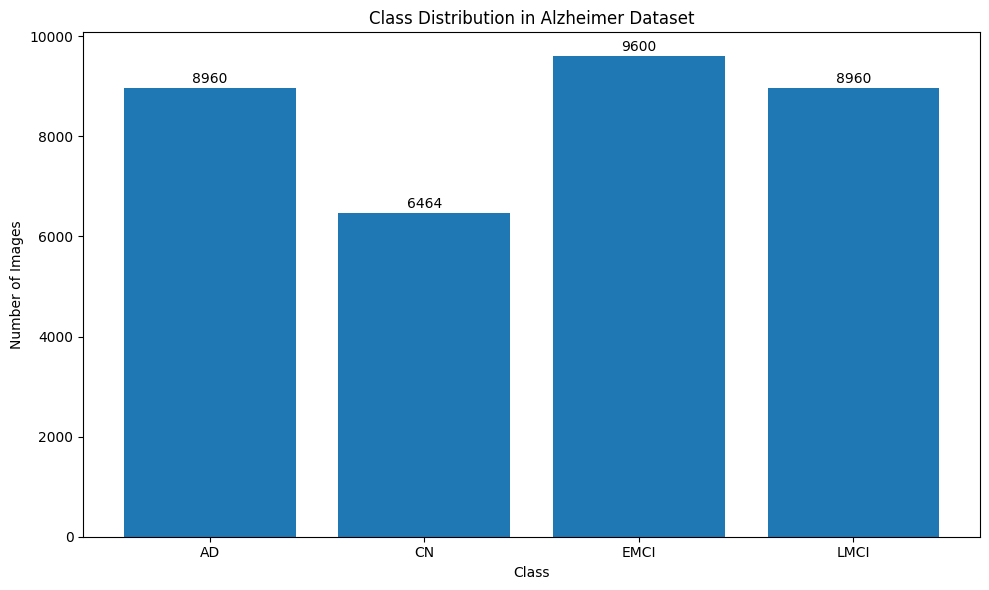

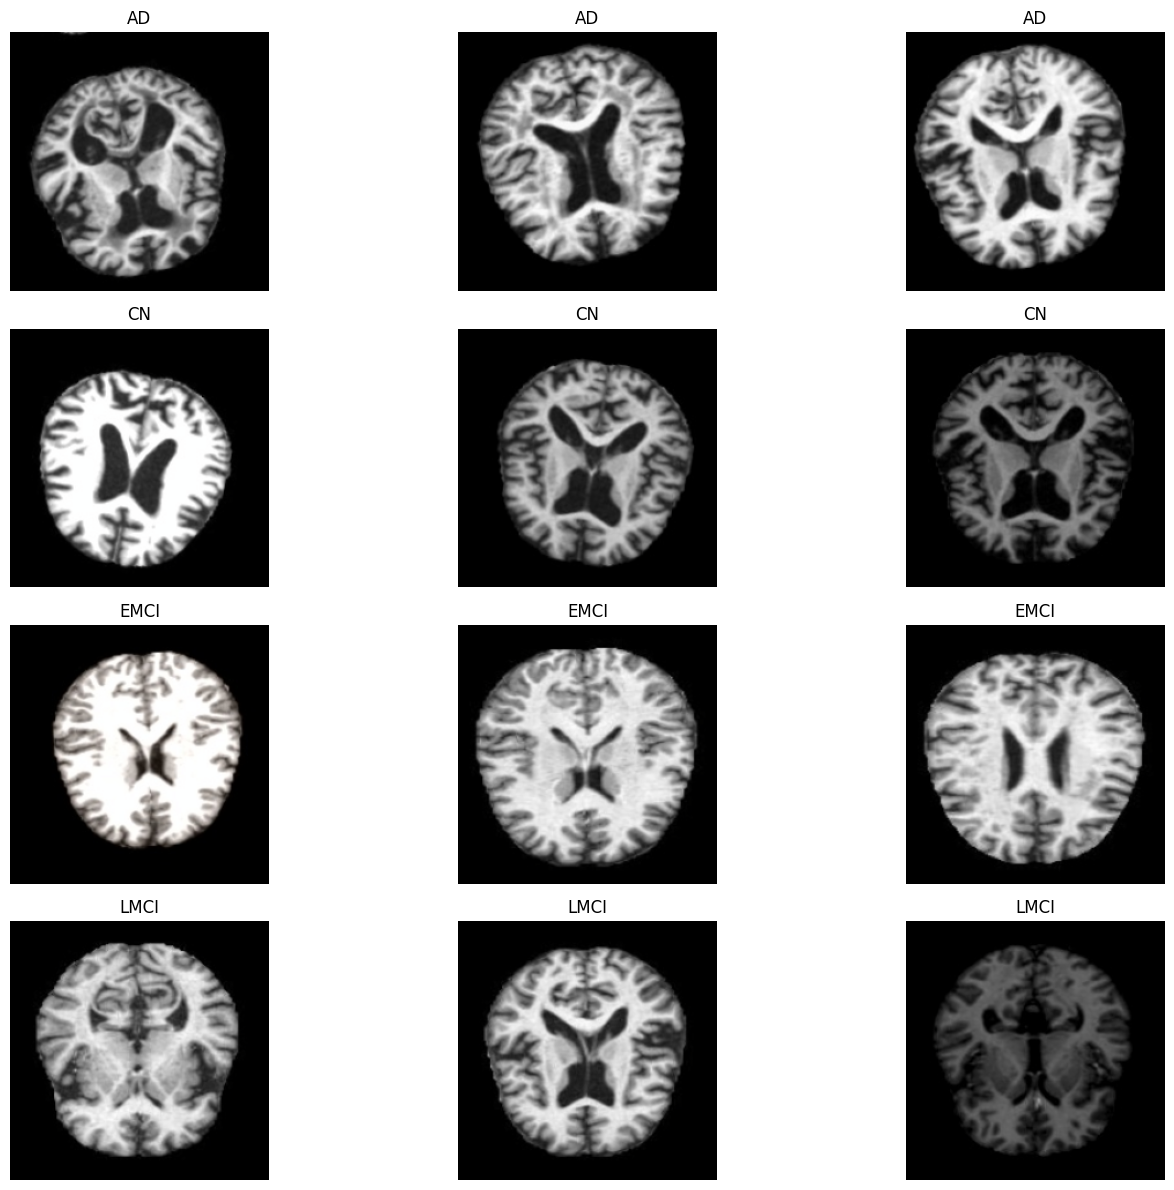

Using MPS device


In [3]:
# Import functions from alzheimer_vit.py
from alzheimer_vit import (
    AlzheimerDataset, 
    data_transforms, 
    dataset, 
    train_loader, 
    val_loader, 
    model, 
    criterion, 
    optimizer, 
    scheduler, 
    load_model,
    show_samples, 
    train_with_progressive_unfreezing, 
    evaluate_model, 
    save_model,
    get_vit_model
)

# Check if CUDA is available
# device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# Check for MPS (Metal Performance Shaders) for Apple Silicon Macs
if torch.backends.mps.is_available():
    device = torch.device("mps")
    print("Using MPS device")
elif torch.cuda.is_available():
    device = torch.device("cuda:0")
    print("Using CUDA device")
else:
    device = torch.device("cpu")
    print("Using CPU device")


## 1. Data Exploration and Visualization

Let's explore the dataset and visualize some sample images.

In [4]:
# Print dataset information
print(f"Total number of samples: {len(dataset)}")
print(f"Number of training samples: {len(train_loader.dataset)}")
print(f"Number of validation samples: {len(val_loader.dataset)}")
print(f"Number of classes: {len(dataset.classes)}")
print(f"Classes: {dataset.classes}")


Total number of samples: 33984
Number of training samples: 27187
Number of validation samples: 6797
Number of classes: 4
Classes: ['AD', 'CN', 'EMCI', 'LMCI']


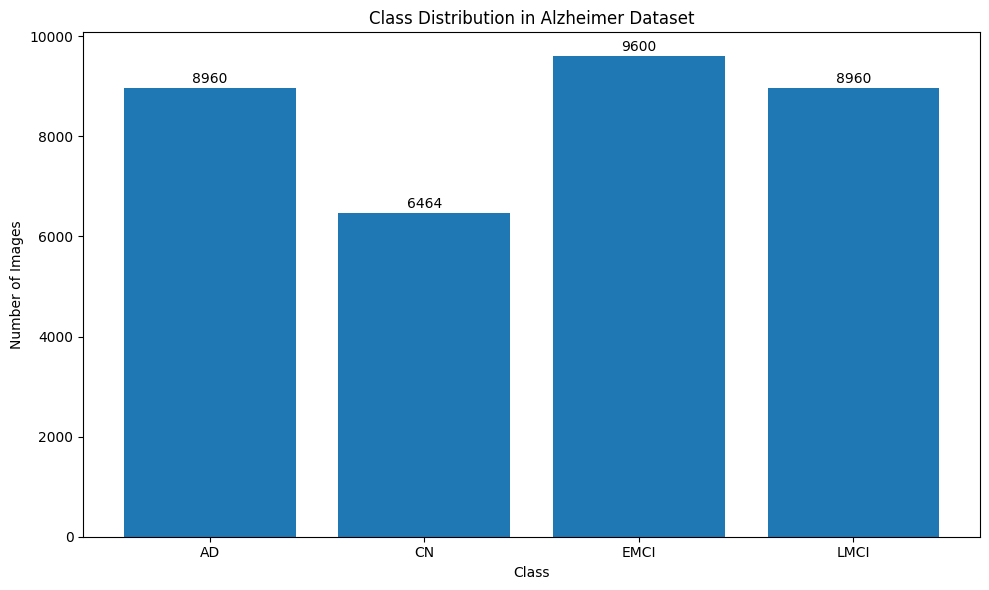

In [5]:
# Visualize class distribution
import matplotlib.pyplot as plt
import numpy as np

class_counts = {}
for _, label in dataset.samples:
    class_name = dataset.classes[label]
    if class_name in class_counts:
        class_counts[class_name] += 1
    else:
        class_counts[class_name] = 1

plt.figure(figsize=(10, 6))
plt.bar(class_counts.keys(), class_counts.values())
plt.title('Class Distribution in Alzheimer Dataset')
plt.xlabel('Class')
plt.ylabel('Number of Images')
plt.xticks(rotation=0)
for i, (key, value) in enumerate(class_counts.items()):
    plt.text(i, value + 100, str(value), ha='center')
plt.tight_layout()
plt.show()


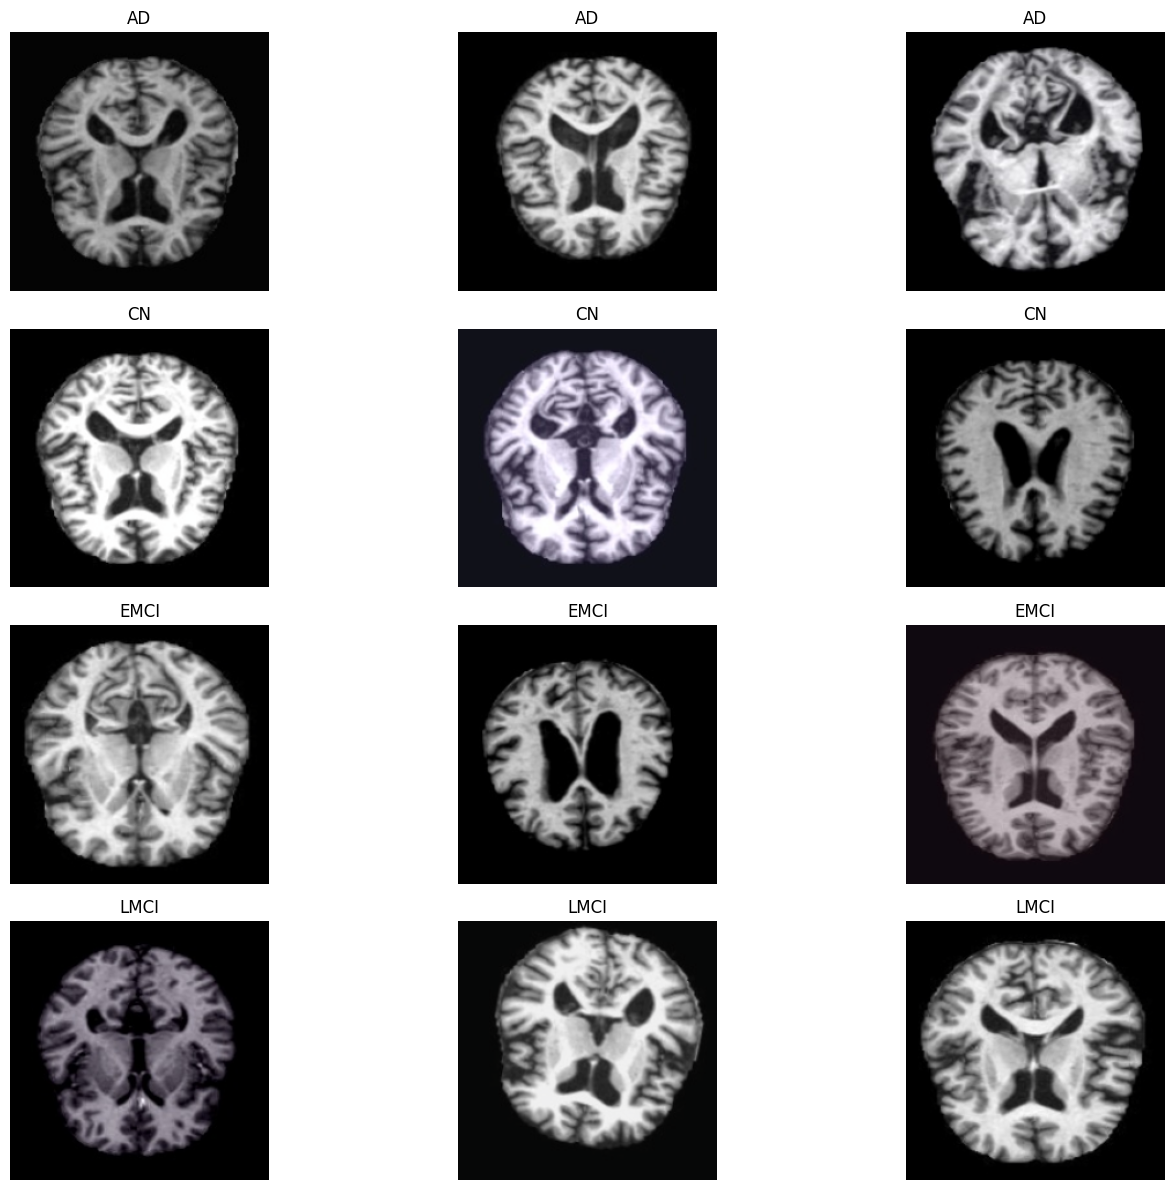

In [6]:
# Show sample images from each class
show_samples(dataset)


## 2. Model Training

Now let's train our Vision Transformer model.

In [7]:
# Print model summary
print(model)

# Print number of parameters
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Total parameters: {total_params:,}")
print(f"Trainable parameters: {trainable_params:,}")


VisionTransformer(
  (conv_proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
  (encoder): Encoder(
    (dropout): Dropout(p=0.0, inplace=False)
    (layers): Sequential(
      (encoder_layer_0): EncoderBlock(
        (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (self_attention): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
        )
        (dropout): Dropout(p=0.0, inplace=False)
        (ln_2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (mlp): MLPBlock(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU(approximate='none')
          (2): Dropout(p=0.0, inplace=False)
          (3): Linear(in_features=3072, out_features=768, bias=True)
          (4): Dropout(p=0.0, inplace=False)
        )
      )
      (encoder_layer_1): EncoderBlock(
        (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (self_a

In [8]:
# Initialize the model
model = get_vit_model(num_classes=len(dataset.classes))
model = model.to(device)

# Define loss function
criterion = nn.CrossEntropyLoss()

Phase 1: Train classification head only
------------------------------
Epoch 1/10
----------


train:   0%|          | 0/850 [00:00<?, ?it/s]

Using MPS device
PyTorch version: 2.6.0
Figure(1000x600)
Figure(1500x1200)
Using MPS device
PyTorch version: 2.6.0
Figure(1000x600)
Figure(1500x1200)
Using MPS device
PyTorch version: 2.6.0
Figure(1000x600)
Figure(1500x1200)
Using MPS device
PyTorch version: 2.6.0
Figure(1000x600)
Figure(1500x1200)


train: 100%|██████████| 850/850 [04:26<00:00,  3.19it/s]


train Loss: 0.8865 Acc: 0.6110


val:   0%|          | 0/213 [00:00<?, ?it/s]

Using MPS device
PyTorch version: 2.6.0
Figure(1000x600)
Figure(1500x1200)
Using MPS device
PyTorch version: 2.6.0
Figure(1000x600)
Figure(1500x1200)
Using MPS device
PyTorch version: 2.6.0
Figure(1000x600)
Figure(1500x1200)
Using MPS device
PyTorch version: 2.6.0
Figure(1000x600)
Figure(1500x1200)


val: 100%|██████████| 213/213 [01:34<00:00,  2.24it/s]


val Loss: 0.7607 Acc: 0.6756

Epoch 2/10
----------


train:   0%|          | 0/850 [00:00<?, ?it/s]

Using MPS device
PyTorch version: 2.6.0
Figure(1000x600)
Figure(1500x1200)
Using MPS device
PyTorch version: 2.6.0
Figure(1000x600)
Figure(1500x1200)
Using MPS device
PyTorch version: 2.6.0
Figure(1000x600)
Figure(1500x1200)
Using MPS device
PyTorch version: 2.6.0
Figure(1000x600)
Figure(1500x1200)


train: 100%|██████████| 850/850 [04:29<00:00,  3.15it/s]


train Loss: 0.7245 Acc: 0.6881


val:   0%|          | 0/213 [00:00<?, ?it/s]

Using MPS device
PyTorch version: 2.6.0
Figure(1000x600)
Figure(1500x1200)
Using MPS device
PyTorch version: 2.6.0
Figure(1000x600)
Figure(1500x1200)
Using MPS device
PyTorch version: 2.6.0
Figure(1000x600)
Figure(1500x1200)
Using MPS device
PyTorch version: 2.6.0
Figure(1000x600)
Figure(1500x1200)


val: 100%|██████████| 213/213 [01:38<00:00,  2.17it/s]


val Loss: 0.7002 Acc: 0.6960

Epoch 3/10
----------


train:   0%|          | 0/850 [00:00<?, ?it/s]

Using MPS device
PyTorch version: 2.6.0
Figure(1000x600)
Figure(1500x1200)
Using MPS device
PyTorch version: 2.6.0
Figure(1000x600)
Figure(1500x1200)
Using MPS device
PyTorch version: 2.6.0
Figure(1000x600)
Figure(1500x1200)
Using MPS device
PyTorch version: 2.6.0
Figure(1000x600)
Figure(1500x1200)


train: 100%|██████████| 850/850 [04:43<00:00,  3.00it/s]


train Loss: 0.6797 Acc: 0.7138


val:   0%|          | 0/213 [00:00<?, ?it/s]

Using MPS device
PyTorch version: 2.6.0
Figure(1000x600)
Figure(1500x1200)
Using MPS device
PyTorch version: 2.6.0
Figure(1000x600)
Figure(1500x1200)
Using MPS device
PyTorch version: 2.6.0
Figure(1000x600)
Figure(1500x1200)
Using MPS device
PyTorch version: 2.6.0
Figure(1000x600)
Figure(1500x1200)


val: 100%|██████████| 213/213 [01:41<00:00,  2.10it/s]


val Loss: 0.6898 Acc: 0.7119

Phase 2: Fine-tune last few transformer layers
------------------------------
Unfrozen 0 parameters in the last 4 encoder layers
Epoch 4/10
----------


train:   0%|          | 0/850 [00:00<?, ?it/s]

Using MPS device
PyTorch version: 2.6.0
Figure(1000x600)
Figure(1500x1200)
Using MPS device
PyTorch version: 2.6.0
Figure(1000x600)
Figure(1500x1200)
Using MPS device
PyTorch version: 2.6.0
Figure(1000x600)
Figure(1500x1200)
Using MPS device
PyTorch version: 2.6.0
Figure(1000x600)
Figure(1500x1200)


train: 100%|██████████| 850/850 [04:34<00:00,  3.09it/s]


train Loss: 0.6663 Acc: 0.7217


val:   0%|          | 0/213 [00:00<?, ?it/s]

Using MPS device
PyTorch version: 2.6.0
Figure(1000x600)
Figure(1500x1200)
Using MPS device
PyTorch version: 2.6.0
Figure(1000x600)
Figure(1500x1200)
Using MPS device
PyTorch version: 2.6.0
Figure(1000x600)
Figure(1500x1200)
Using MPS device
PyTorch version: 2.6.0
Figure(1000x600)
Figure(1500x1200)


val: 100%|██████████| 213/213 [01:44<00:00,  2.04it/s]


val Loss: 0.6732 Acc: 0.7130

Epoch 5/10
----------


train:   0%|          | 0/850 [00:00<?, ?it/s]

Using MPS device
PyTorch version: 2.6.0
Figure(1000x600)
Figure(1500x1200)
Using MPS device
PyTorch version: 2.6.0
Figure(1000x600)
Figure(1500x1200)
Using MPS device
PyTorch version: 2.6.0
Figure(1000x600)
Figure(1500x1200)
Using MPS device
PyTorch version: 2.6.0
Figure(1000x600)
Figure(1500x1200)


train: 100%|██████████| 850/850 [04:22<00:00,  3.24it/s]


train Loss: 0.6604 Acc: 0.7241


val:   0%|          | 0/213 [00:00<?, ?it/s]

Using MPS device
PyTorch version: 2.6.0
Figure(1000x600)
Figure(1500x1200)
Using MPS device
PyTorch version: 2.6.0
Figure(1000x600)
Figure(1500x1200)
Using MPS device
PyTorch version: 2.6.0
Figure(1000x600)
Figure(1500x1200)
Using MPS device
PyTorch version: 2.6.0
Figure(1000x600)
Figure(1500x1200)


val: 100%|██████████| 213/213 [01:35<00:00,  2.22it/s]


val Loss: 0.6691 Acc: 0.7150

Epoch 6/10
----------


train:   0%|          | 0/850 [00:00<?, ?it/s]

Using MPS device
PyTorch version: 2.6.0
Figure(1000x600)
Figure(1500x1200)
Using MPS device
PyTorch version: 2.6.0
Figure(1000x600)
Figure(1500x1200)
Using MPS device
PyTorch version: 2.6.0
Figure(1000x600)
Figure(1500x1200)
Using MPS device
PyTorch version: 2.6.0
Figure(1000x600)
Figure(1500x1200)


train: 100%|██████████| 850/850 [04:41<00:00,  3.02it/s]


train Loss: 0.6562 Acc: 0.7271


val:   0%|          | 0/213 [00:00<?, ?it/s]

Using MPS device
PyTorch version: 2.6.0
Figure(1000x600)
Figure(1500x1200)
Using MPS device
PyTorch version: 2.6.0
Figure(1000x600)
Figure(1500x1200)
Using MPS device
PyTorch version: 2.6.0
Figure(1000x600)
Figure(1500x1200)
Using MPS device
PyTorch version: 2.6.0
Figure(1000x600)
Figure(1500x1200)


val: 100%|██████████| 213/213 [01:34<00:00,  2.26it/s]


val Loss: 0.6675 Acc: 0.7138

Phase 3: Full fine-tuning
------------------------------
Epoch 7/10
----------


train:   0%|          | 0/850 [00:00<?, ?it/s]

Using MPS device
PyTorch version: 2.6.0
Figure(1000x600)
Figure(1500x1200)
Using MPS device
PyTorch version: 2.6.0
Figure(1000x600)
Figure(1500x1200)
Using MPS device
PyTorch version: 2.6.0
Figure(1000x600)
Figure(1500x1200)
Using MPS device
PyTorch version: 2.6.0
Figure(1000x600)
Figure(1500x1200)


train: 100%|██████████| 850/850 [12:57<00:00,  1.09it/s]


train Loss: 0.4316 Acc: 0.8183


val:   0%|          | 0/213 [00:00<?, ?it/s]

Using MPS device
PyTorch version: 2.6.0
Figure(1000x600)
Figure(1500x1200)
Using MPS device
PyTorch version: 2.6.0
Figure(1000x600)
Figure(1500x1200)
Using MPS device
PyTorch version: 2.6.0
Figure(1000x600)
Figure(1500x1200)
Using MPS device
PyTorch version: 2.6.0
Figure(1000x600)
Figure(1500x1200)


val: 100%|██████████| 213/213 [02:00<00:00,  1.77it/s]


val Loss: 0.2137 Acc: 0.9238

Epoch 8/10
----------


train:   0%|          | 0/850 [00:00<?, ?it/s]

Using MPS device
PyTorch version: 2.6.0
Figure(1000x600)
Figure(1500x1200)
Using MPS device
PyTorch version: 2.6.0
Figure(1000x600)
Figure(1500x1200)
Using MPS device
PyTorch version: 2.6.0
Figure(1000x600)
Figure(1500x1200)
Using MPS device
PyTorch version: 2.6.0
Figure(1000x600)
Figure(1500x1200)


train: 100%|██████████| 850/850 [14:31<00:00,  1.03s/it] 


train Loss: 0.1136 Acc: 0.9605


val:   0%|          | 0/213 [00:00<?, ?it/s]

Using MPS device
PyTorch version: 2.6.0
Figure(1000x600)
Figure(1500x1200)
Using MPS device
PyTorch version: 2.6.0
Figure(1000x600)
Figure(1500x1200)
Using MPS device
PyTorch version: 2.6.0
Figure(1000x600)
Figure(1500x1200)
Using MPS device
PyTorch version: 2.6.0
Figure(1000x600)
Figure(1500x1200)


val: 100%|██████████| 213/213 [01:46<00:00,  2.01it/s]


val Loss: 0.1415 Acc: 0.9470

Epoch 9/10
----------


train:   0%|          | 0/850 [00:00<?, ?it/s]

Using MPS device
PyTorch version: 2.6.0
Figure(1000x600)
Figure(1500x1200)
Using MPS device
PyTorch version: 2.6.0
Figure(1000x600)
Figure(1500x1200)
Using MPS device
PyTorch version: 2.6.0
Figure(1000x600)
Figure(1500x1200)
Using MPS device
PyTorch version: 2.6.0
Figure(1000x600)
Figure(1500x1200)


train: 100%|██████████| 850/850 [14:26<00:00,  1.02s/it]  


train Loss: 0.0203 Acc: 0.9958


val:   0%|          | 0/213 [00:00<?, ?it/s]

Using MPS device
PyTorch version: 2.6.0
Figure(1000x600)
Figure(1500x1200)
Using MPS device
PyTorch version: 2.6.0
Figure(1000x600)
Figure(1500x1200)
Using MPS device
PyTorch version: 2.6.0
Figure(1000x600)
Figure(1500x1200)
Using MPS device
PyTorch version: 2.6.0
Figure(1000x600)
Figure(1500x1200)


val: 100%|██████████| 213/213 [01:57<00:00,  1.82it/s]


val Loss: 0.0825 Acc: 0.9728

Epoch 10/10
----------


train:   0%|          | 0/850 [00:00<?, ?it/s]

Using MPS device
PyTorch version: 2.6.0
Figure(1000x600)
Figure(1500x1200)
Using MPS device
PyTorch version: 2.6.0
Figure(1000x600)
Figure(1500x1200)
Using MPS device
PyTorch version: 2.6.0
Figure(1000x600)
Figure(1500x1200)
Using MPS device
PyTorch version: 2.6.0
Figure(1000x600)
Figure(1500x1200)


train: 100%|██████████| 850/850 [14:07<00:00,  1.00it/s]  


train Loss: 0.0046 Acc: 0.9999


val:   0%|          | 0/213 [00:00<?, ?it/s]

Using MPS device
PyTorch version: 2.6.0
Figure(1000x600)
Figure(1500x1200)
Using MPS device
PyTorch version: 2.6.0
Figure(1000x600)
Figure(1500x1200)
Using MPS device
PyTorch version: 2.6.0
Figure(1000x600)
Figure(1500x1200)
Using MPS device
PyTorch version: 2.6.0
Figure(1000x600)
Figure(1500x1200)


val: 100%|██████████| 213/213 [01:26<00:00,  2.45it/s]


val Loss: 0.0611 Acc: 0.9788

Training complete in 100m 24s
Best val Acc: 0.9788


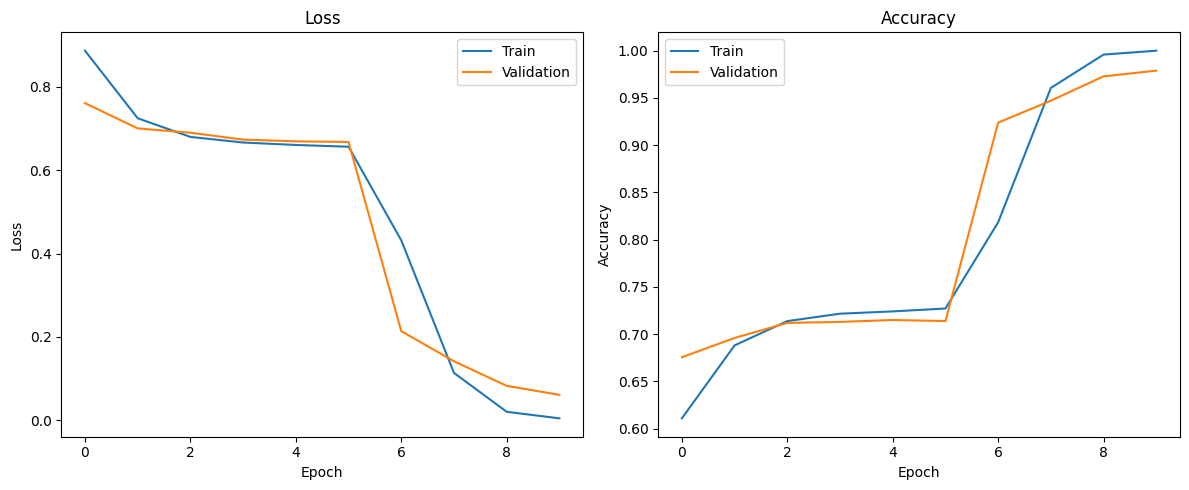

In [9]:
# Train the model
num_epochs = 10
# Train with progressive unfreezing
model, history = train_with_progressive_unfreezing(model, criterion, num_epochs=10)

## 3. Model Evaluation

After training, we can evaluate the model's performance.

Evaluating:   0%|          | 0/213 [00:00<?, ?it/s]

Using MPS device
PyTorch version: 2.6.0
Figure(1000x600)
Figure(1500x1200)
Using MPS device
PyTorch version: 2.6.0
Figure(1000x600)
Figure(1500x1200)
Using MPS device
PyTorch version: 2.6.0
Figure(1000x600)
Figure(1500x1200)
Using MPS device
PyTorch version: 2.6.0
Figure(1000x600)
Figure(1500x1200)


Evaluating: 100%|██████████| 213/213 [01:26<00:00,  2.47it/s]

Test Accuracy: 0.9788


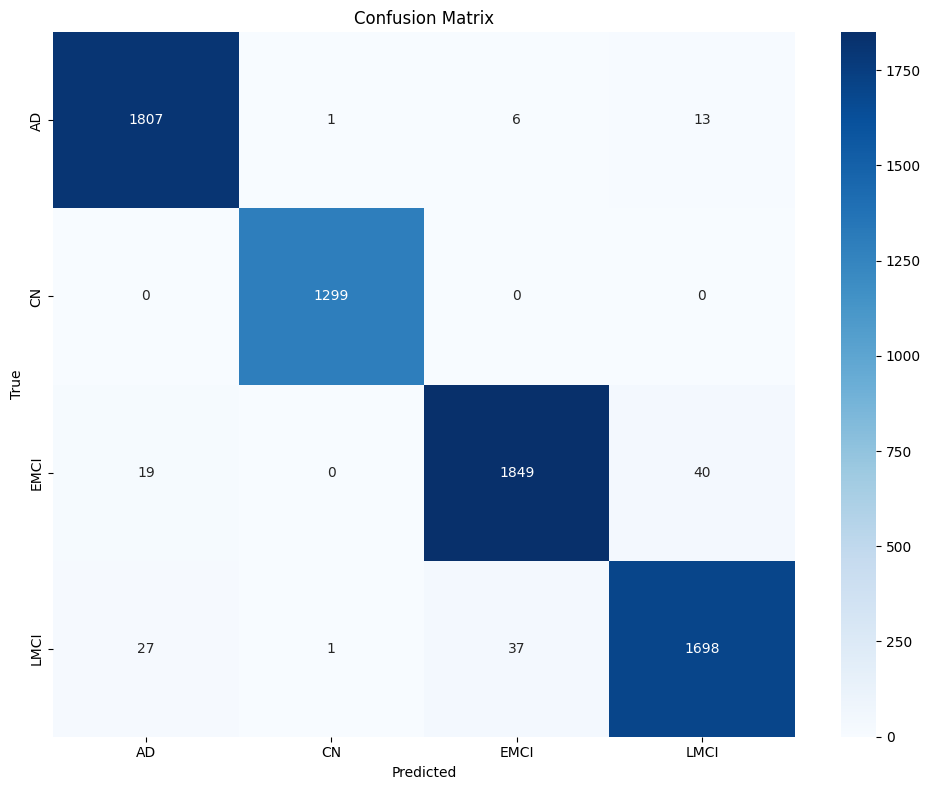


Classification Report:
              precision    recall  f1-score   support

          AD       0.98      0.99      0.98      1827
          CN       1.00      1.00      1.00      1299
        EMCI       0.98      0.97      0.97      1908
        LMCI       0.97      0.96      0.97      1763

    accuracy                           0.98      6797
   macro avg       0.98      0.98      0.98      6797
weighted avg       0.98      0.98      0.98      6797



In [10]:
# Evaluate the model
evaluate_model(model, val_loader)


In [12]:
# Save the model
save_model(model, 'vit_alzheimer_model.pth')


Model saved to vit_alzheimer_model.pth


In [11]:
loaded_model, classes, class_to_idx = load_model('vit_alzheimer_model.pth')

Model loaded from vit_alzheimer_model.pth
Classes: ['AD', 'CN', 'EMCI', 'LMCI']


## 4. Model Interpretation

Let's visualize some predictions from our model.

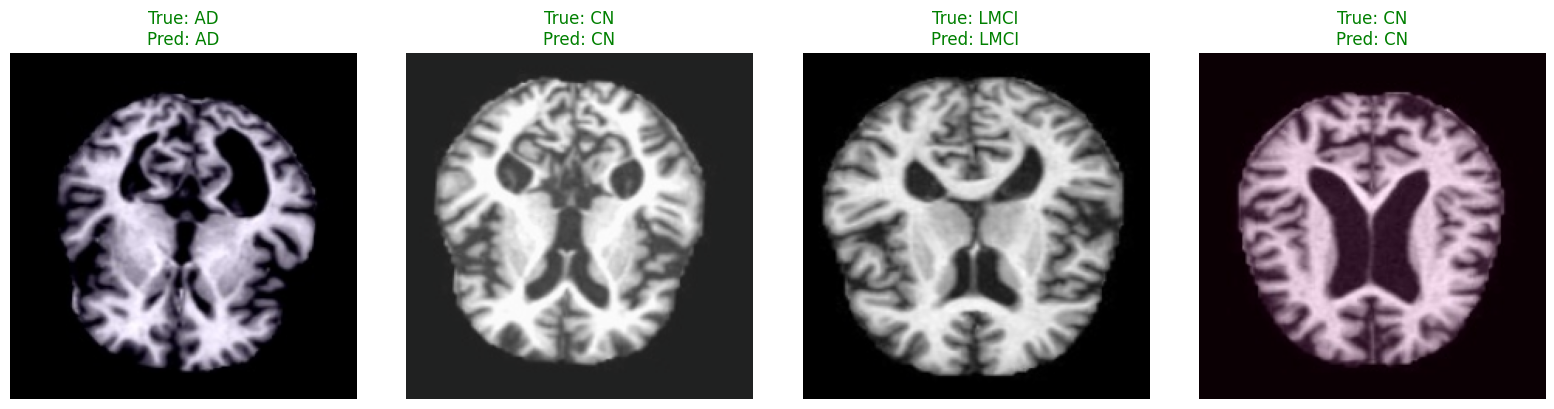

In [13]:
# Function to visualize predictions
import random
from PIL import Image
from alzheimer_vit import visualize_predictions
# Visualize predictions
visualize_predictions(model, dataset)